<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/2_Crop_Disease_Detection_Transfer_Learning_and_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop Disease Detection using Transfer Learning - Fully Fixed Version

In [7]:
!pip install -q tensorflow tensorflow-hub matplotlib Pillow opencv-python seaborn scikit-learn

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import os
from PIL import Image
import io
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
# Create a sample dataset structure
def create_sample_dataset():
    """Create a sample dataset structure with synthetic leaf images."""
    classes = ['healthy', 'diseased']

    # Create directory structure
    for split in ['train', 'validation']:
        for class_name in classes:
            os.makedirs(f'./crop_data/{split}/{class_name}', exist_ok=True)

    # Generate synthetic images
    for class_name in classes:
        for split in ['train', 'validation']:
            base_path = f'./crop_data/{split}/{class_name}'
            num_images = 10 if split == 'train' else 5

            for i in range(num_images):
                # Create base leaf image
                img = np.ones((224, 224, 3), dtype=np.uint8) * 255

                # Draw leaf shape
                leaf_center = (112, 112)

                if class_name == 'healthy':
                    # Green healthy leaf
                    base_color = (34, 139, 34)  # Forest green
                    img[:, :] = (50, 150, 50)  # Light green background

                    # Draw main leaf
                    cv2.ellipse(img, leaf_center, (80, 40), 0, 0, 360, base_color, -1)

                    # Add veins
                    cv2.line(img, (32, 112), (192, 112), (25, 100, 25), 2)
                    for j in range(4):
                        y_offset = 30 - j * 15
                        cv2.line(img, (112, 112), (60, 112 + y_offset), (25, 100, 25), 1)
                        cv2.line(img, (112, 112), (164, 112 + y_offset), (25, 100, 25), 1)
                else:
                    # Diseased leaf
                    base_color = (34, 100, 34)  # Darker green
                    img[:, :] = (80, 120, 80)  # Grayish green background

                    # Draw main leaf
                    cv2.ellipse(img, leaf_center, (80, 40), 0, 0, 360, base_color, -1)

                    # Add disease spots
                    for _ in range(15):
                        spot_x = np.random.randint(40, 184)
                        spot_y = np.random.randint(72, 152)
                        spot_radius = np.random.randint(3, 12)
                        spot_color = (np.random.randint(100, 180),
                                    np.random.randint(60, 120),
                                    np.random.randint(0, 60))
                        cv2.circle(img, (spot_x, spot_y), spot_radius, spot_color, -1)

                    # Add edge browning
                    cv2.ellipse(img, leaf_center, (85, 45), 0, 0, 360, (101, 67, 33), 3)

                # Add noise for realism
                noise = np.random.normal(0, 10, img.shape)
                img = np.clip(img + noise, 0, 255).astype(np.uint8)

                # Save image
                img_path = os.path.join(base_path, f'{class_name}_{split}_{i}.jpg')
                Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).save(img_path)

    print("Sample dataset created successfully!")

In [10]:
# Create the sample dataset
create_sample_dataset()

Sample dataset created successfully!


In [11]:
# Set up data paths
data_dir = './crop_data'

In [12]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


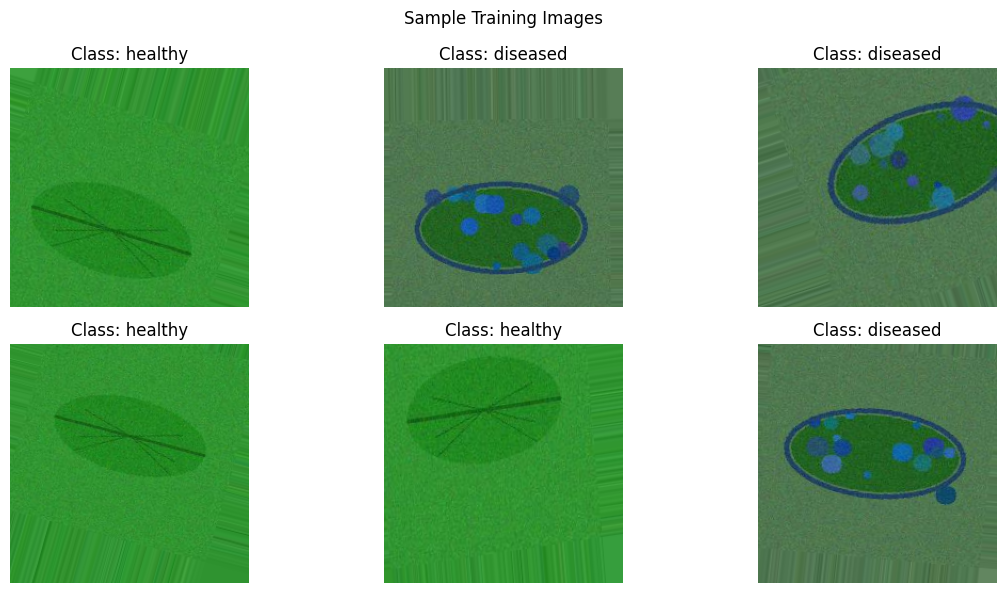

In [14]:
# Display sample images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img_batch, label_batch = next(train_generator)
    img = img_batch[0]
    label = label_batch[0]
    plt.imshow(img)
    plt.title(f'Class: {list(train_generator.class_indices.keys())[np.argmax(label)]}')
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

In [15]:
# Build transfer learning model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

In [16]:
# Freeze base model
base_model.trainable = False

In [17]:
# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [18]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
print("Model Summary:")
model.summary()

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,074 (9.99 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# Phase 1: Feature extraction training
print("\nPhase 1: Training with feature extraction...")
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Let's check what metrics are available
print("\nAvailable metrics in history:")
print("History keys:", history.history.keys())


Phase 1: Training with feature extraction...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7375 - loss: 0.4226 - val_accuracy: 1.0000 - val_loss: 0.0285
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 1.0000 - loss: 0.0594 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 2.1635e-04
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 9.7384e-05
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 1.0000 - loss: 5.9513e-04 - val_accuracy: 1.0000 - val_loss: 2.8131e-05

Available metrics in history:
History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [21]:
# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning the model...")

# Unfreeze some layers
base_model.trainable = True
fine_tune_at = 100

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=3,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator
)

# Visualize combined training results
plt.figure(figsize=(12, 4))


Phase 2: Fine-tuning the model...


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

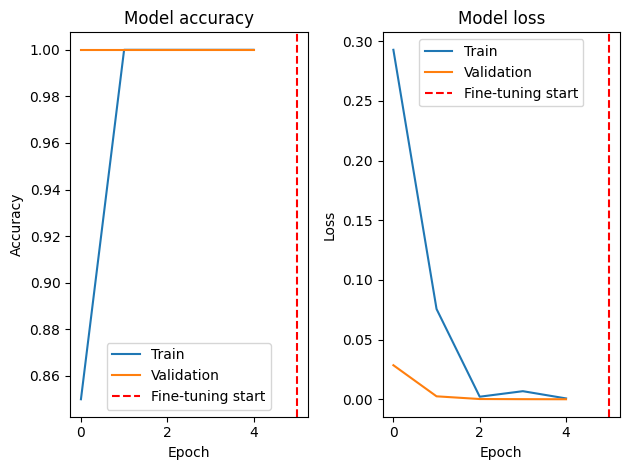

In [22]:
# Get the metric names (they might be different in different TF versions)
acc_metric = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_metric = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

# Combine histories for plotting
try:
    acc = history.history[acc_metric] + history_fine.history[acc_metric]
    val_acc = history.history[val_acc_metric] + history_fine.history[val_acc_metric]
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
except KeyError as e:
    print(f"Warning: {e}")
    acc = history.history.get(acc_metric, [])
    val_acc = history.history.get(val_acc_metric, [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.axvline(x=5, color='r', linestyle='--')  # Mark where fine-tuning starts
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Fine-tuning start'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.axvline(x=5, color='r', linestyle='--')  # Mark where fine-tuning starts
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Fine-tuning start'])

plt.tight_layout()
plt.show()

In [23]:
# Disease classification function
def predict_disease(img_path):
    """Predict crop disease from image."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array, verbose=0)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    return predicted_class, confidence


--- Testing Predictions ---


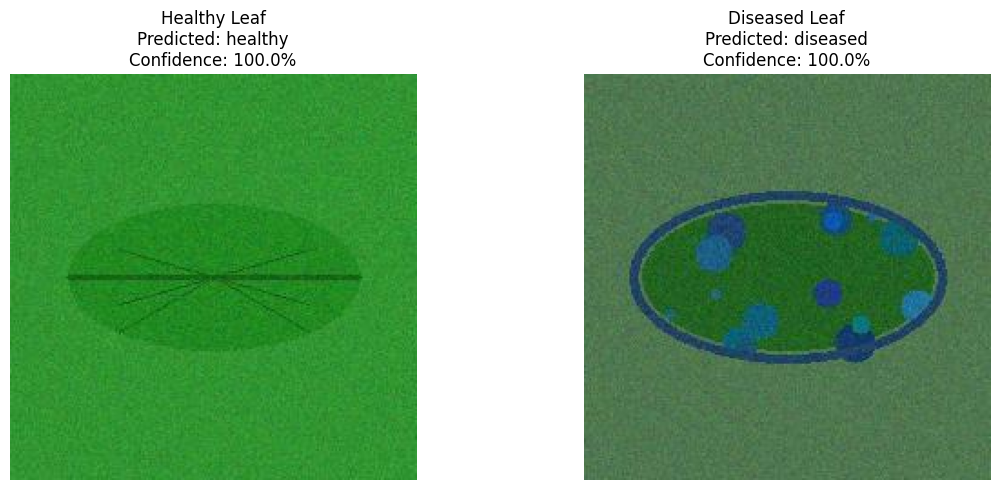

In [24]:
# Test predictions
print("\n--- Testing Predictions ---")

# Get sample images
healthy_sample = os.path.join(data_dir, 'validation/healthy', 'healthy_validation_0.jpg')
diseased_sample = os.path.join(data_dir, 'validation/diseased', 'diseased_validation_0.jpg')

# Visualize predictions
plt.figure(figsize=(12, 5))

test_images = [healthy_sample, diseased_sample]
titles = ['Healthy Leaf', 'Diseased Leaf']

for i, (img_path, title) in enumerate(zip(test_images, titles)):
    plt.subplot(1, 2, i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')

    pred_class, conf = predict_disease(img_path)
    plt.title(f"{title}\nPredicted: {pred_class}\nConfidence: {conf:.1%}")

plt.tight_layout()
plt.show()

In [25]:
# Save model
model.save('crop_disease_detection_model.h5')
print("\nModel saved successfully!")


Model saved successfully!



--- Creating Confusion Matrix ---


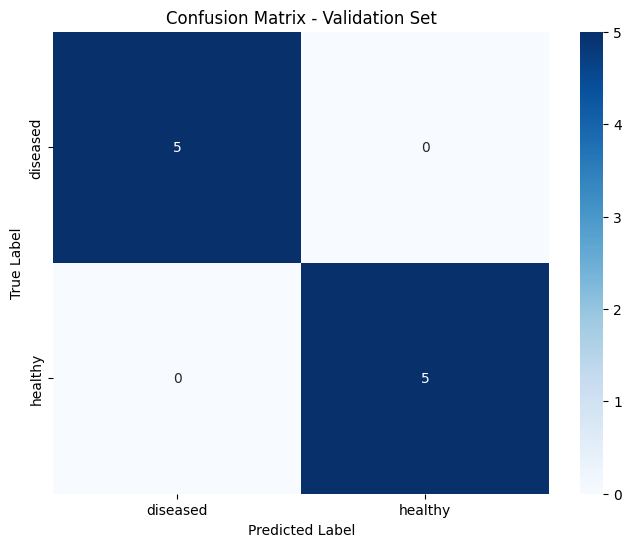

In [26]:
# Create confusion matrix
print("\n--- Creating Confusion Matrix ---")

# Get predictions for validation set
val_predictions = []
val_labels = []

# Reset generator
validation_generator.reset()

# Collect predictions
for _ in range(len(validation_generator)):
    img_batch, label_batch = next(validation_generator)
    predictions = model.predict(img_batch, verbose=0)
    val_predictions.extend(np.argmax(predictions, axis=1))
    val_labels.extend(np.argmax(label_batch, axis=1))

# Plot confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
# Final summary
print("\nCrop Disease Detection Summary:")
print("--------------------------------")
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {validation_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Classes: {list(train_generator.class_indices.keys())}")
print(f"Final training accuracy: {acc[-1]:.2%}" if acc else "N/A")
print(f"Final validation accuracy: {val_acc[-1]:.2%}" if val_acc else "N/A")


Crop Disease Detection Summary:
--------------------------------
Training samples: 20
Validation samples: 10
Number of classes: 2
Classes: ['diseased', 'healthy']
Final training accuracy: 100.00%
Final validation accuracy: 100.00%
